<a href="https://colab.research.google.com/github/jjangmo91/Cervus-nippon_Anmado-Is./blob/main/Cervus-nippon_Anmado-Is.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Earth Engine을 활용한 안마도 식생 분석
Google Earth Engine과 Colab을 이용하여, 안마도의 유기된 대만꽃사슴의 증가와 그로 인한 피해를 조사하는 프로젝트입니다.
안마도에 사슴이 들어온 1985년부터, 30여년간의 피해 상황을 시계열 분석을 통하여 식생 변화를 알아보겠습니다.
<br><br>
분석 단계는 다음과 같습니다:
* 분석에 필요한 API와 라이브러리를 호출합니다.
* 분석을 위한 관심 영역(AOI)을 설정합니다.
* 30년여간의 위성 데이터(Landsat)를 수집합니다.
* Landsat 데이터를 활용하여 구름 없는 대기 보정 이미지를 생산합니다.
* NDVI 계산을 수행하고, 다년도 이미지에 대해 탐색적 데이터 분석(EDA)과 전처리를 진행합니다.
* NDVI 변화에 대해 시계열 분석을 진행합니다.

## 1. Google Earth Engine 초기화 및 필요 라이브러리 로드


In [1]:
# Earth Engine Python API 모듈 및 라이브러리 호출
import ee
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal
import requests
import json
import os
import shutil
import psutil
from google.colab import drive
import zipfile

# Earth Engine 인증
ee.Authenticate()

# Earth Engine 초기화
ee.Initialize(project='ee-jjangmo91')

## 2. 관심 영역(AOI) 설정
안마도의 위치를 관심 영역(AOI: Area of Interest)으로 설정합니다.

In [5]:
# 안마도의 위치를 기반으로 관심 지역을 설정합니다.
anmado_location = ee.Geometry.Point([126.028111, 35.344031])
aoi = anmado_location.buffer(5000).bounds()  # 버퍼와 경계 설정

# 연구지역 경계를 지도에 추가
outline = ee.Image().byte().paint(featureCollection=aoi, color=1, width=3)

# 지도 객체 생성
Map = geemap.Map(center=[35.344031, 126.028111], zoom=12)
Map.addLayer(outline, {'palette': 'FF0000'}, "Study Area")
Map.centerObject(aoi, 7)
Map

Map(center=[35.34403541471917, 126.02820130275431], controls=(WidgetControl(options=['position', 'transparent_…

## 3. 위성 이미지 수집
위성 이미지 데이터를 시계열로 수집하여 분석합니다. 여기서는 Landsat5(TM), Landsat8(OLI/TIRS) 이미지를 사용합니다.
<br>
* Landsat5는 미국 지질 조사국(USGS)과 나사(NASA)가 공동으로 운영하는 Landsat 위성 프로그램의 일부로, 1984년 3월에 발사되어 2013년까지 약 29년 동안 운영되었습니다. 전 세계를 대상으로 16일마다 재방문하는 광역(wide-swath), 중간 해상도(medium-resolution) 다중 스펙트럼(multispectral) 이미징 임무를 수행했습니다. 이 위성의 Thematic Mapper(TM) 센서는 7개의 분광 밴드를 포함하며, 가시광선 및 근적외선(NIR)을 30미터, 열적외선을 120미터(재조정으로 30미터) 공간 해상도로 측정합니다. 이를 통해 식생, 토양, 수체의 상태 및 변화를 평가하는 데 적합한 데이터를 제공합니다.

* Landsat8은 2013년에 발사되었으며, Landsat5와 마찬가지로 16일마다 재방문하는
광역(wide-swath), 중간 해상도(medium-resolution), 다중 스펙트럼 이미징 임무(multispectral imaging mission)입니다. Landsat8의 두 주요 센서인 Operational Land Imager(OLI)와 Thermal Infrared Sensor(TIRS)는 다양한 분광 밴드를 취급합니다. OLI는 가시광선 및 근적외선(NIR)을 30미터, 해안/에어로졸 밴드를 30미터 해상도로, TIRS는 두 개의 열적외선 밴드를 통해 100미터 해상도로 측정합니다. 이는 지표 온도, 식생, 토양, 수체의 상태 및 변화를 평가하는 데 적합한 데이터를 제공하여 농업, 산림, 도시 계획 및 환경 관리 등에 광범위하게 활용됩니다.
<br>
아래의 함수는 pixel_qa 레이어의 비트마스크를 사용하여 구름, 구름 그림자, 눈이 있는 픽셀을 식별하고 제거합니다. 이렇게 처리된 이미지는 맑은 조건의 지표면 반사율 정보만을 포함하게 되어, NDVI와 같은 지표를 계산할 때 오류의 가능성을 줄여 줍니다. 비트 마스크의 각 값은 구름은 5번, 구름 그림자는 3번, 눈은 4번 비트를 사용합니다. 마지막으로, 대기 보정된 데이터를 스케일링하기 위해 10000으로 나누어 정규화된 반사율 값을 얻습니다. 이 함수를 사용하여 Landsat 5 및 8 이미지 컬렉션에 적용하고, NDVI 계산과 같은 후속 분석을 수행할 수 있습니다.

* Pixel QA(Quality Assessment) layer는 위성 이미지의 각 픽셀에 대한 품질 정보를 담고 있는 레이어입니다. 이 레이어는 각 픽셀의 품질을 평가하는 다양한 정보를 비트로 인코딩하여 제공합니다. 이를 통해 특정 픽셀이 구름, 구름 그림자, 눈, 물 등의 상태에 있는지 여부를 판단할 수 있습니다. 각 비트는 특정 품질 상태를 나타내며, 이러한 정보를 통해 데이터 전처리 및 분석 시 불필요한 픽셀을 필터링할 수 있습니다.

* Bitmask는 픽셀의 특정 품질 상태를 나타내는 비트를 선택하고 조작하기 위해 사용됩니다. 비트마스크를 사용하여 특정 비트가 설정되었는지 확인하고, 이를 통해 해당 상태에 있는 픽셀을 필터링하거나 선택할 수 있습니다.

* Landsat 이미지 데이터는 원래의 반사율 값이 0에서 1사이의 값이디만. 하지만, 저장 및 처리의 효율성을 위해 이 값을 일정한 스케일 팩터(보통 10000)로 곱한 후 정수 형태로 저장합니다. 예를 들어, 0.1234라면, 이를 10000으로 곱하여 1234로 저장합니다. 이를 다시 원래 값으로 변환하려면, 10000으로 나눠야 합니다.

In [6]:
def maskLandsatClouds(image):
    # QA_PIXEL 레이어 선택
    qa = image.select('QA_PIXEL')

    # 비트 마스킹을 통해 구름(clouds), 구름 그림자(cloud shadows), 눈(snow) 식별
    cloud = qa.bitwiseAnd(1 << 5)
    cloudShadow = qa.bitwiseAnd(1 << 3)
    snow = qa.bitwiseAnd(1 << 4)

    # 구름, 그림자, 눈이 없는 맑은 상태의 이미지 마스크 생성
    mask = cloud.eq(0).And(cloudShadow.eq(0)).And(snow.eq(0))

    # 마스크를 적용하고, 스케일 조정을 위해 결과를 10000으로 나눔
    return image.updateMask(mask).divide(10000)

Landsat 5 TM과 Landsat 8 OLI/TIRS 위성 이미지를 선택하고 필터링하는 과정을 수행합니다. 구체적으로 1985년부터 2024년 4월 28일까지의 기간 동안 촬영된 이미지를 대상으로 안마도 지역에 해당하는 이미지를 필터링합니다. 또한, 'pixel_qa' 레이어를 사용하여 구름과 그림자를 제거하여 맑은 상태의 이미지만을 추출하는 과정을 포함합니다. -> Collection1 서비스 종료, Collection2로 교체

In [10]:
# Landsat 5 TM 이미지 선택 및 필터링 (Collection 2 데이터 세트 사용)
landsat5_images = (
    ee.ImageCollection("LANDSAT/LT05/C02/T1_L2")
    .filterDate("1985-01-01", "2012-05-05")  # Landsat 5 운영 기간
    .filterBounds(aoi)
    .map(maskLandsatClouds)  # 구름 및 그림자 마스킹 함수 적용
)

# Landsat 8 OLI/TIRS 이미지 선택 및 필터링 (Collection 2 데이터 세트 사용)
landsat8_images = (
    ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
    .filterDate("2013-04-11", "2024-01-31")  # Landsat 8 운영 기간
    .filterBounds(aoi)
    .map(maskLandsatClouds)  # 구름 및 그림자 마스킹 함수 적용
)

# 각 이미지 컬렉션의 이미지 개수 확인
image_count_l5 = landsat5_images.size()
image_count_l8 = landsat8_images.size()

# 이미지 개수 출력
print("Landsat 5 image count:", image_count_l5.getInfo())
print("Landsat 8 image count:", image_count_l8.getInfo())

Landsat 5 image count: 781
Landsat 8 image count: 376


# 4. NDVI 계산 및 시계열 데이터 전처리

Landsat 5와 Landsat 8의 NDVI 계산 시, 밴드 번호가 다릅니다. 따라서 NDVI 계산을 위한 함수를 두 가지로 나누어 정의합니다.

In [11]:
# NDVI 계산 함수 정의
def calculate_ndvi_landsat5(image):
    ndvi = image.normalizedDifference(['SR_B4', 'SR_B3']).rename('NDVI')  # B4: NIR, B3: RED
    return image.addBands(ndvi)

def calculate_ndvi_landsat8(image):
    ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')  # B5: NIR, B4: RED
    return image.addBands(ndvi)

이제 각 Landsat 이미지 컬렉션에 대해 NDVI를 계산한 후, 이들을 병합합니다.

In [12]:
# NDVI 계산
landsat5_ndvi = landsat5_images.map(calculate_ndvi_landsat5)
landsat8_ndvi = landsat8_images.map(calculate_ndvi_landsat8)

# 두 컬렉션을 병합
all_ndvi = landsat5_ndvi.merge(landsat8_ndvi)

관심 지역(AOI)에서 각 날짜별로 평균(중앙값) NDVI 값을 계산하여 시계열 데이터로 변환합니다.

In [13]:
import re

# 이미지 ID에서 날짜 추출하는 함수 (서버 측에서 실행)
def extract_date_from_id(image):
    # 이미지의 ID를 가져옴
    img_id = image.get('system:index')

    # GEE의 ee.String과 정규 표현식을 사용해 서버 측에서 날짜 추출
    date_str = ee.String(img_id).slice(-8)

    # 날짜 문자열을 'YYYY-MM-DD' 형식으로 변환
    formatted_date = ee.Date.parse('yyyyMMdd', date_str).format('YYYY-MM-dd')

    return formatted_date

# AOI에 대한 NDVI 시계열 추출 (ID에서 날짜 추출)
def calculate_ndvi_time_series(img):
    # AOI에 대한 NDVI 중앙값 계산
    median_ndvi = img.reduceRegion(
        reducer=ee.Reducer.median(),
        geometry=aoi,
        scale=30
    )

    # 이미지 ID에서 날짜 추출
    date = extract_date_from_id(img)

    # 결과를 이미지의 속성으로 설정
    return img.set('NDVI', median_ndvi.get('NDVI')).set('date', date)

# 이미지 컬렉션에서 각 이미지에 대해 NDVI 시계열 계산
ndvi_timeseries = all_ndvi.map(calculate_ndvi_time_series)

# 결과를 리스트로 변환
ndvi_list = ndvi_timeseries.reduceColumns(ee.Reducer.toList(2), ['date', 'NDVI']).get('list').getInfo()

          date      NDVI
0   1985-01-22 -0.057849
295 1985-01-22 -0.058442
1   1985-02-07 -0.082804
296 1985-02-07 -0.079401
2   1985-06-15 -0.021727


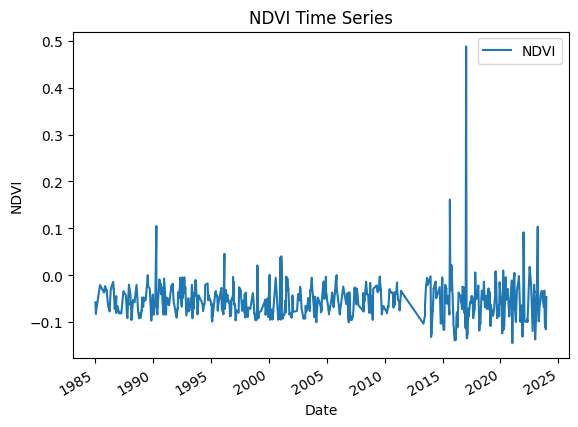

In [18]:
# NDVI 데이터프레임 생성 및 시각화
if len(ndvi_list) > 0:
    dates, ndvi_values = zip(*ndvi_list)
    df = pd.DataFrame({'date': pd.to_datetime(dates), 'NDVI': ndvi_values})

    # 날짜별로 정렬
    df = df.sort_values(by='date')

    # NDVI 시계열 데이터 출력
    print(df.head())

    # NDVI 시계열 데이터 시각화
    df.plot(x='date', y='NDVI', title='NDVI Time Series', xlabel='Date', ylabel='NDVI')
    plt.show()
else:
    print("No valid NDVI data found.")

## 3-1. 데이터 저장
Colab에서 30년치의 위성 데이터를 사용하기에는 너무 많은 양일 수 있습니다. 따라서 다음과 같은 과정으로 로컬 컴퓨터에 데이터를 저장하여 사용하겠습니다.

Google Earth Engine을 활용하는 Colab 환경에서는 데이터를 직접 로컬 파일 시스템에 저장할 수 없습니다. 대신, 데이터를 Colab의 `/content`디렉토리에 저장한 후, 이를 로컬 컴퓨터로 다운로드하는 과정을 거쳐야 합니다.

Colab에서 '/content' 디렉토리의 용도
* 디스크 저장소: '/content' 디렉토리는 Colab 인스턴스의 디스크 저장소로 사용됩니다. 데이터 파일, 모델 체크포인트, 다운로드한 파일 등을 저장할 수 있습니다.
* 데이터 보존: 세션이 활성화되어 있는 동안, '/content' 디렉토리에 저장된 데이터는 유지됩니다. 세션이 종료되면 데이터는 사라집니다.

먼저 현재 작업 디렉토리의 환경을 체크해봅니다.

In [15]:
# 현재 작업 디렉토리 출력
print("Current working directory:", os.getcwd())

# 디스크 사용량 확인
total, used, free = shutil.disk_usage("/content")
print("Total disk space: %d GB" % (total // (2**30)))
print("Used disk space: %d GB" % (used // (2**30)))
print("Free disk space: %d GB" % (free // (2**30)))

# 메모리 사용량 확인
memory_info = psutil.virtual_memory()
print("Total memory: %d GB" % (memory_info.total // (2**30)))
print("Available memory: %d GB" % (memory_info.available // (2**30)))
print("Used memory: %d GB" % (memory_info.used // (2**30)))

Current working directory: /content
Total disk space: 107 GB
Used disk space: 30 GB
Free disk space: 76 GB
Total memory: 12 GB
Available memory: 11 GB
Used memory: 1 GB


GEE에서 제공되는 메타데이터의 "sysyem:time_start" 속성을 통해 이미지가 촬영된 날짜와 시간 정보를 파일 이름에 포함시켜 다운로드하며  '/content' 디렉토리에 데이터를 저장합니다.

In [ ]:
# 다운로드 함수 정의
def download_image(image, description, folder):
    try:
        # Get the download URL
        url = image.getDownloadURL({
            'scale': 30,
            'region': AOI.getInfo()['coordinates']
        })
        # Send a request to the URL with a timeout
        response = requests.get(url, timeout=300)
        response.raise_for_status()  # Raise an exception for HTTP errors

        # Save the file
        file_path = os.path.join(folder, f'{description}.zip')
        with open(file_path, 'wb') as file:
            file.write(response.content)
        print(f"Downloaded {description}")
    except requests.exceptions.RequestException as e:
        print(f"Failed to download {description}: {e}")

# Google Drive 마운트
drive.mount('/content/drive')

# Google Drive 내에 저장할 디렉토리 경로
drive_folder = '/content/drive/My Drive/Cervus-nippon_Anmado-Is'

# Google Drive에 디렉토리가 없으면 생성합니다.
os.makedirs(drive_folder, exist_ok=True)

# Create folders to save images
landsat5_folder = os.path.join(drive_folder, 'Landsat5')
landsat8_folder = os.path.join(drive_folder, 'Landsat8')
os.makedirs(landsat5_folder, exist_ok=True)
os.makedirs(landsat8_folder, exist_ok=True)

# Clear previous downloads if needed (optional)
for folder in [landsat5_folder, landsat8_folder]:
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print(f'Failed to delete {file_path}. Reason: {e}')

# 다운로드 및 날짜 포함 파일명 생성
landsat5_list = landsat5_images.toList(image_count_l5)
landsat8_list = landsat8_images.toList(image_count_l8)

# Download Landsat 5 images
for i in range(image_count_l5):
    image = ee.Image(landsat5_list.get(i))
    date = image.get('system:time_start').getInfo()
    if date:
        date_str = ee.Date(date).format('YYYY-MM-dd').getInfo()
        description = f'Landsat5_{date_str}'
        if not os.path.exists(os.path.join(landsat5_folder, f'{description}.zip')):
            download_image(image, description, landsat5_folder)
        else:
            print(f"Skipped {description}, already exists.")
    else:
        print(f"Skipped image at index {i}, no date found.")

# Download Landsat 8 images
for i in range(image_count_l8):
    image = ee.Image(landsat8_list.get(i))
    date = image.get('system:time_start').getInfo()
    if date:
        date_str = ee.Date(date).format('YYYY-MM-dd').getInfo()
        description = f'Landsat8_{date_str}'
        if not os.path.exists(os.path.join(landsat8_folder, f'{description}.zip')):
            download_image(image, description, landsat8_folder)
        else:
            print(f"Skipped {description}, already exists.")
    else:
        print(f"Skipped image at index {i}, no date found.")

# 압축 해제 함수
def zip_folder(folder_name, zip_path):
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(folder_name):
            for file in files:
                zipf.write(os.path.join(root, file))

# 압축 파일을 Google Drive에 저장
landsat5_zip_path = os.path.join(drive_folder, 'Landsat5.zip')
zip_folder(landsat5_folder, landsat5_zip_path)

landsat8_zip_path = os.path.join(drive_folder, 'Landsat8.zip')
zip_folder(landsat8_folder, landsat8_zip_path)

print("Compressed files have been saved to Google Drive.")

KeyboardInterrupt: 

## 4. NDVI 계산 및 통계치 산출하기

정규식생지수(NDVI)는 센서 데이터를 사용하여 식생의 건강과 밀도를 정량화하는 데 널리 사용되는 지표입니다. 이 지표는 적색과 근적외선 두 특정 밴드에서의 분광 데이터를 기반으로 계산됩니다. 이러한 분광 데이터는 보통 위성과 같은 원격 센서에서 수집됩니다.

NDVI는 높은 정확성 때문에 산업계에서 인기가 있습니다. 실제 지상 식생 상태와의 상관관계가 높기 때문입니다. NDVI는 해석하기도 쉬운데, -1에서 1 사이의 값을 가집니다. 식물이 전혀 자라지 않는 지역은 NDVI 값이 0이 됩니다. NDVI는 식생의 성장에 비례하여 증가하며, 밀도가 높고 건강한 식생이 있는 지역은 NDVI 값이 1이 됩니다. NDVI 값이 0보다 작으면 건조한 땅이 부족하다는 것을 나타냅니다. 예를 들어, 바다는 NDVI 값이 -1이 됩니다.

프리즘을 통해 볼 수 있듯이, 태양광 스펙트럼은 다양한 파장으로 구성되어 있습니다. 태양광이 물체에 비추어질 때, 특정 파장은 흡수되고 다른 파장은 반사됩니다. 식물 잎의 색소인 클로로필(chlorophyll)은 광합성에 사용되는 가시광선을 강하게 흡수합니다. 반면에, 잎의 세포 구조는 근적외선을 강하게 반사합니다.



NDVI 계산 함수 정의 NDVI= (NIR-RED) / (NIR+RED)

Landsat 5 TM 위성에서는 B4가 근적외선(NIR) 밴드, B3가 적색(Red) 밴드입니다.

Landsat 8 OLI에서는 B5가 근적외선(NIR) 밴드, B4가 적색(Red) 밴드입니다.



NDVI 계산 및 데이터 수집
이미지 컬렉션에서 각 이미지의 NDVI 값을 계산하고 날짜별로 수집합니다.

필터링된 이미지 컬렉션 내의 모든 이미지들로부터 밴드별 중간값을 계산하여 새로운 단일 이미지를 생성합니다. 이는 구름이 적은 여러 날짜의 이미지들을 통합하여 더 깨끗한 대표 이미지를 얻기 위해 사용됩니다. 이미지는 RGB 컬러로 표시합니다. Landsat5에서 B3, B2, B1는 각각 적색, 녹색, 청색 색상에 해당하며, Landsat8에서는 B4, B3, B2가 각각 적색, 녹색, 청색에 해당합니다.

In [ ]:
# Landsat 5 TM 이미지 중간값 계산
landsat5_median = landsat5_images.median()

# Landsat 8 OLI/TIRS 이미지 중간값 계산
landsat8_median = landsat8_images.median()

# 시각화를 위한 매개변수 설정
visualization_l5 = {
    'min': 0.0,
    'max': 0.3,
    'bands': ['B3', 'B2', 'B1'],
}

visualization_l8 = {
    'min': 0.0,
    'max': 0.3,
    'bands': ['B4', 'B3', 'B2'],
}

# 지도 객체 생성
Map = geemap.Map(width="800px", height="500px")

# Landsat 5 TM 및 Landsat 8 OLI/TIRS 중간값 이미지를 지도에 추가
Map.add_layer(landsat5_median, visualization_l5, 'Landsat 5 RGB')
Map.add_layer(landsat8_median, visualization_l8, 'Landsat 8 RGB')

# 지도의 중심을 관심 지역(AOI)에 맞춤
Map.centerObject(AOI, 13)

# 지도 객체 출력
Map

Map(center=[35.34403612944367, 126.02811117438931], controls=(WidgetControl(options=['position', 'transparent_…

## 4. NDVI 계산 및 통계치 산출하기
프리즘을 통해 볼 수 있듯이, 태양광 스펙트럼은 많은 다른 파장으로 구성되어 있습니다. 태양광이 물체에 비추어질 때, 특정 파장은 흡수되고 다른 파장은 반사됩니다. 식물 잎의 색소인 클로로필(chlorophyll)은 광합성에 사용되는 가시광선을 강하게 흡수합니다. 반면에, 잎의 세포 구조는 근적외선을 강하게 반사합니다. 나무가 클로로필과 클로로필을 포함하는 잎을 더 많이 가질수록, 이러한 파장의 빛은 더 많이 영향을 받습니다. 과학자들은 식물이 빛과 상호작용하는 이 지식을 활용하여 지구 표면 전역의 식물이 흡수하고 반사하는 적색과 근적외선의 파장을 측정하기 위해 위성 센서를 설계함으로써 지구의 풍경을 통틀어 녹색 식생 밀도를 매핑합니다.

식물이 반사하는 적색 빛의 반사율을 근적외선 빛의 반사율에서 빼고, 그 차이를 적색과 근적외선 빛의 반사율의 합으로 나누면 과학자들이 정규식생지수(NDVI: Normalized Difference Vegetation Index)라고 부르는 값을 얻을 수 있습니다.

Landsat 5 TM 및 Landsat 8 OLI/TIRS 위성 이미지를 사용하여 NDVI를 계산하고 시각화하는 과정을 아래와 같이 설계할 수 있습니다:

Landsat 5 TM
Landsat 5 TM 위성에서는 B4가 근적외선(NIR) 밴드, B3가 적색(Red) 밴드입니다.

In [ ]:
from ipyleaflet import TileLayer

# Vworld 배경지도 객체
vworld_base = TileLayer(
    url='https://xdworld.vworld.kr/2d/Base/service/{z}/{x}/{y}.png',
    name='Vworld Base',
    attribution='Vworld',
)

# Landsat 5 TM 이미지에서 NDVI 계산
ndvi_l5 = landsat5_images.median().normalizedDifference(['B4', 'B3'])

# NDVI 색상 팔레트 정의
ndvi_palette = [
    'FE8374',  # 낮은 NDVI - 갈색
    'FED976',  # 낮은-중간 NDVI - 밝은 녹색
    'CAE23C',  # 중간 NDVI - 녹색
    '98B718',  # 중간-높은 NDVI - 진한 녹색
    '059033',  # 높은 NDVI - 매우 진한 녹색
]

# Vworld 하이브리드지도 객체
vworld_hybrid = TileLayer(
    url='https://xdworld.vworld.kr/2d/Hybrid/service/{z}/{x}/{y}.png',
    name='Vworld Hybrid',
    attribution='Vworld',
)

# NDVI 시각화 및 지도에 추가
Map = geemap.Map(width="800px", height="500px")
Map.add_layer(ndvi_l5, {'min': 0, 'max': 0.5, 'palette': ndvi_palette}, 'NDVI Landsat 5')
Map.add_layer(vworld_hybrid)
Map.centerObject(AOI, 13) # 지도의 중심 설정
Map # 지도 객체 출력

Map(center=[35.34403612944367, 126.02811117438931], controls=(WidgetControl(options=['position', 'transparent_…

Landsat 8 OLI/TIRS

Landsat 8 OLI에서는 B5가 근적외선(NIR) 밴드, B4가 적색(Red) 밴드입니다.

In [ ]:
# Landsat 8 OLI/TIRS 이미지에서 NDVI 계산
ndvi_l8 = landsat8_images.median().normalizedDifference(['B5', 'B4'])

# NDVI 시각화 및 지도에 추가
Map.add_layer(ndvi_l8, {'min': 0, 'max': 0.5, 'palette': ndvi_palette}, 'NDVI Landsat 8')

지도 구성 및 출력
지도에 두 NDVI 계층을 추가하고, 지도를 출력합니다.

In [ ]:
# 지도 객체 생성
Map = geemap.Map(width="800px", height="500px")
Map.add_layer(ndvi_l5, {'min': 0, 'max': 0.5, 'palette': ndvi_palette}, 'NDVI Landsat 5')
Map.add_layer(ndvi_l8, {'min': 0, 'max': 0.5, 'palette': ndvi_palette}, 'NDVI Landsat 8')
Map.centerObject(AOI, 13)  # 지도의 중심 설정
Map  # 지도 객체 출력

NameError: name 'ndvi_l5' is not defined

이 부분 포함해서 위에 과정에서 데이터 merge하고, 수정해야 함 <---- 이상적(Landsat5, 8을 단순히 정규화해서 합쳐도 되는지, 아니면 파장영역의 차이로 다른 방법을 통해서 보정을 해줘야 할 것 같은데, 논문 찾아보고 이해하는데 시간 오래걸릴 수도?있으니 다른 방법으로 일단 진행을 해보자)

1. 시계열 데이터 통합 및 분석
각 이미지의 NDVI를 계산한 후, 중간값을 이용해 장기간에 걸쳐 시계열 데이터를 통합합니다.
이를 통해 각 시간대별 대표적인 식생 상태를 나타내는 이미지를 생성합니다.


2. NDVI 통계치 산출
통합된 이미지에서 NDVI의 최소값, 최대값, 평균값, 중간값 등 표준편차를 계산합니다.
이 통계치는 식생 변화의 추세를 이해하는 데 중요합니다.


3. 결과 시각화 및 보고
계산된  NDVI 및 통계치를 사용하여 시간에 따른 식생 변화를 시각합니다.
안마도 생태계 변화를 모니터링하고, 장기적인 환경 변화 추세를 평가하는 데 사용됩니다.


평가


----------------------------------------------------------------------------



마지막으로, Sentinel-2 이미지를 기반으로 계산된 NDVI에 대한 다양한 통계치를 계산하고, 이를 데이터프레임으로 변환하여 CSV 파일로 저장하는 과정을 수행합니다.

reduceRegion 메서드를 사용하여 지정된 지역(AOI)에서 NDVI의 최소값, 평균값, 중간값, 최대값, 표준편차를 계산합니다. 이는 ee.Reducer 객체를 사용하여 여러 통계치를 결합함으로써 한 번의 연산으로 여러 통계치를 얻습니다. scale 파라미터는 해상도를 10m로 설정하며, maxPixels 파라미터는 처리할 최대 픽셀 수(1e9는 10억 개)를 지정합니다.

In [ ]:
# NDVI 통계치 계산 (최소값, 평균, 중간값, 최대값, 표준편차)
stats = ndvi_l5.reduceRegion(
    reducer=ee.Reducer.min()
    .combine(reducer2=ee.Reducer.mean(), sharedInputs=True)
    .combine(reducer2=ee.Reducer.median(), sharedInputs=True)
    .combine(reducer2=ee.Reducer.max(), sharedInputs=True)
    .combine(reducer2=ee.Reducer.stdDev(), sharedInputs=True),
    geometry=AOI,
    scale=30,
    maxPixels=1e9,
)

# 통계치 결과를 DataFrame으로 변환
df_stats = pd.DataFrame(
    [stats.getInfo()],
    columns=["nd_min", "nd_mean", "nd_median", "nd_max", "nd_stdDev"],
    index=["AOI"],
)
df_stats.columns = ["Min", "Mean", "Median", "Max", "StdDev"]

# DataFrame을 CSV 파일로 저장하기
df_stats.to_csv('df_stats.csv', index=True)

# NDVI 통계치 출력
print(df_stats)

          Min      Mean    Median       Max    StdDev
AOI -0.421638 -0.253671 -0.325015  0.643217  0.226122


In [ ]:
# 시스템 시간 속성이 있는지 확인하는 필터링 함수
def filter_has_time_start(image):
    return ee.Image(image.set('has_time_start', image.propertyNames().contains('system:time_start')))

# Landsat 5 이미지 컬렉션 로드 및 필터링
landsat5_images = (
    ee.ImageCollection("LANDSAT/LT05/C01/T1_SR")
    .filterDate("1985-01-01", "2012-05-05")
    .filterBounds(AOI)
    .map(maskLandsatClouds)
    .map(filter_has_time_start)
    .filter(ee.Filter.eq('has_time_start', True))
)

# NDVI 계산 함수
def calculate_ndvi(image):
    ndvi = image.normalizedDifference(['B4', 'B3']).rename('NDVI')
    date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')
    mean_ndvi = ndvi.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=AOI,
        scale=30,
        maxPixels=1e9
    ).get('NDVI')
    return image.set('mean_ndvi', mean_ndvi).set('date', date)

# NDVI 계산 및 이미지 컬렉션 생성
ndvi_images = landsat5_images.map(calculate_ndvi)

# 필요한 정보 추출
features = ndvi_images.getInfo()['features']

# NDVI 정보 추출 및 변환 함수
def get_ndvi_info(feature):
    properties = feature['properties']
    date = properties.get('date')
    mean_ndvi = properties.get('mean_ndvi')
    return {'date': date, 'NDVI': mean_ndvi}

# 리스트로 변환
ndvi_data = [get_ndvi_info(f) for f in features if 'date' in f['properties']]

# 데이터프레임으로 변환
df_ndvi = pd.DataFrame(ndvi_data)

# 날짜 형식 변환
df_ndvi['date'] = pd.to_datetime(df_ndvi['date'], errors='coerce')

# 데이터프레임을 CSV 파일로 저장
df_ndvi.to_csv('landsat5_ndvi.csv', index=False)

# 결과 출력
print(df_ndvi.head())

KeyError: 'date'